In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sympy
from scipy.optimize import curve_fit

def makeFolder(Filename,sep='/'):
    '''file name may contains several folders, so need to check
    individually'''
    subFolderPath = Filename.split('/')
    complete = '.'
    for subFolderP in subFolderPath:
        complete = "/".join([complete,subFolderP])
        dir_path = Path(complete)
        if not dir_path.exists():
            dir_path.mkdir()

def SAVE_dATA( Cdata,Ls,a_list,name):

    dataframe = pd.DataFrame( Cdata )
    dataframe.index = ['L={}'.format(L) for L in Ls ]
    dataframe.columns = [ a1  for a1 in a_list  ]

    dataframe = dataframe.stack()
    dataframe = dataframe.unstack(0)
    dataframe.index.name="T"
    dataframe.to_csv(name )

def get_index(dys):
    for idy in range(len(dys)-1):
        if np.sign(dys[idy]) != np.sign(dys[idy+1]):
            # if np.allclose(1e4*dys[idy],1e4*dys[idy+1]) == False:
            return idy 
    raise ValueError("no crossing point")

def fitting_x0_slope(x, y1, y2):
    cross_index = get_index(y2-y1)
    num_add = 0
    id_range = range(cross_index-num_add, cross_index+num_add + 2)
    a1, c1  = np.polyfit(x[id_range], y1[id_range], 1)
    a2, c2  = np.polyfit(x[id_range], y2[id_range], 1)
    x0 = -(c1-c2)/(a1-a2)
    y0 = a1*x0 + c1
    return x0,y0, a1,a2 , c1,c2

def read_iter_csv(filename, iteration):
    df = pd.read_csv(filename + '_ZoomIter{}.csv'.format(0))
    for i in range(1,iteration+1):
        try:
            df_new = pd.read_csv(filename + '_ZoomIter{}.csv'.format(i))
            df = pd.concat([df,df_new])
            df = df.drop_duplicates(subset=['T'])
            df = df.sort_values('T').reset_index(drop=True)
        except:
            continue
    # df = df[df['T']>=2.2]
    # df = df[df['T']<=2.275]
    return df

kB = 1
J  = 1
Tc = 2.0/np.log(1.0 + np.sqrt(2))

f_inf_integral = 0.929695398341610214985
f_inf_catalan  = ((2*sympy.S.Catalan.n(30))/np.pi + 1/2*np.log(2))
print('f_inf_integral = {}'.format(f_inf_integral))
print('f_inf_catalan  = {}'.format(f_inf_catalan))
print('diff = {}'.format(f_inf_integral - f_inf_catalan))
print(type(f_inf_catalan))

# choose f_inf_catalan, it needs to change it to float64
f_inf = float(f_inf_catalan)

f_inf_integral = 0.9296953983416102
f_inf_catalan  = 0.929695398341610226121240975571
diff = -3.53590445227192543679500510085E-17
<class 'sympy.core.numbers.Float'>


In [3]:
def gammas(T, n):
    beta = 1/(kB*T)
    K  = beta*J
    ls = np.arange(1,2*n)
    gamma_0  = 2*K + np.log(np.tanh(K))   # l = 0
    gamma_ls = np.arccosh(np.cosh(2*K)/np.tanh(2*K)-np.cos(ls*np.pi/n))  # l = 1, 2, 3, ..., 2n-1
    gammas   = np.append(gamma_0, gamma_ls)
    return gammas 

def ln_lambda_0_1(n,T):
    beta = 1/(kB*T)
    K = beta*J 
    ln_lambda_s = np.empty(0)
    
    for parity in ('even', 'odd'):
        if parity == 'even':
            gamma_array = gammas(T,n)[1::2]
        if parity == 'odd':
            gamma_array = gammas(T,n)[0::2]

        """lambda_0 and lambda_1 (all plus-sign for gamma)"""
        ln_lambda_s = np.append(ln_lambda_s, (np.log(2)+np.log(np.sinh(2*K)))*(n/2) + 1/2*np.sum(gamma_array))

    return ln_lambda_s

In [82]:
Ls1 = 2**np.arange(1,10+1)
Ls2 = (3/2*Ls1).astype('int')
Ls = np.sort(np.append(Ls1,Ls2))

iteration = 6

if iteration == 0:
    Ts = np.linspace(2,3,100+1) # Iter0
else:
    FILE_T_iter = 'T_list_iter2'
    Ts = pd.read_csv(FILE_T_iter + '/T_iter_{}_D{}.csv'.format(iteration, dcut))['T'].values

ln_lambda_0_s = np.zeros([len(Ls), len(Ts)])
ln_lambda_1_s = np.zeros([len(Ls), len(Ts)])


for iT,T in enumerate(Ts):
    if iT%10 == 0:
        print('T={}'.format(T))
    for iL,L in enumerate(Ls):
        ln_lambda_0, ln_lambda_1 = ln_lambda_0_1(n=L,T=T)
        ln_lambda_0_s[iL,iT] = ln_lambda_0
        ln_lambda_1_s[iL,iT] = ln_lambda_1

Folder = 'ln_lambda_i_data'
makeFolder(Folder)
SAVE_dATA(ln_lambda_0_s,Ls,Ts,Folder+'/ln_lambda_0 (exact, L_L_over_2)_ZoomIter{}.csv'.format(iteration) )
SAVE_dATA(ln_lambda_1_s,Ls,Ts,Folder+'/ln_lambda_1 (exact, L_L_over_2)_ZoomIter{}.csv'.format(iteration) )

T=2.2607434578
T=2.266911151
T=2.2684915075
T=2.2691497891
T=2.2691785585
T=2.2691848784
T=2.269185193
T=2.2691852843
T=2.2691853038
T=2.2691853184
T=2.2691853361


In [87]:
Ls1 = 2**np.arange(1,10+1)
Ls2 = (3/2*Ls1).astype('int')
Ls = np.sort(np.append(Ls1,Ls2))

iteration = 5

Folder = 'ln_lambda_i_data'
df0 = read_iter_csv(Folder+'/ln_lambda_0 (exact, L_L_over_2)', iteration)
df1 = read_iter_csv(Folder+'/ln_lambda_1 (exact, L_L_over_2)', iteration)
Ts  = df0['T'].values

free_energies = np.zeros([len(Ls), len(Ts)])
corr_lengths  = np.zeros([len(Ls), len(Ts)])

for iL,L in enumerate(Ls):
    ln_lambda_0 = df0['L={}'.format(L)].values
    ln_lambda_1 = df1['L={}'.format(L)].values
    f_L = L**(-1.)*(ln_lambda_0) # semi finite system is considered
    xi  = 1/(ln_lambda_0-ln_lambda_1)
    free_energies[iL,:] =  f_L
    corr_lengths[iL,:]  =  xi

Folder = 'free_energy_data'
makeFolder(Folder)
SAVE_dATA(free_energies,Ls,Ts,Folder+'/f_L (exact, L_L_over_2).csv' )

Folder = 'corr_len_data'
makeFolder(Folder)
SAVE_dATA(corr_lengths,Ls,Ts,Folder+'/xi (exact, L_L_over_2).csv' )

<ipython-input-87-407dc710a581>:19: RuntimeWarning: divide by zero encountered in true_divide
  xi  = 1/(ln_lambda_0-ln_lambda_1)


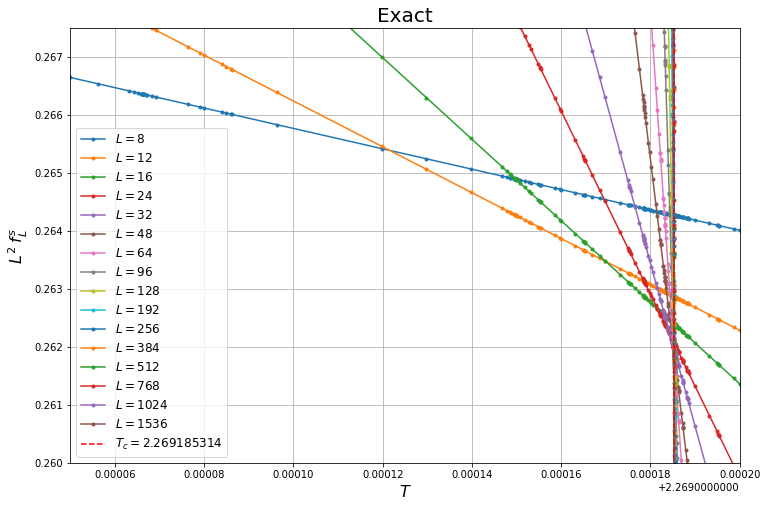

In [4]:
Folder = 'free_energy_data'
f_L_data = pd.read_csv(Folder+'/f_L (exact, L_L_over_2).csv')
f_L_data = f_L_data[(f_L_data['T']>=2.2) & (f_L_data['T']<=2.5)]

ZoomIn = True

Ts    = f_L_data['T'].values

Ls1 = 2**np.arange(3,10+1)
Ls2 = (3/2*Ls1).astype('int')
Ls = np.sort(np.append(Ls1,Ls2))

plt.figure(figsize=(12,8))
for L in Ls:
    if L % 1 == 0:
        f_L = f_L_data['L={}'.format(L)].values
        f_s_L = f_L - f_inf
        x = Ts
        y = (L**2 * f_s_L)

        plt.plot(x, y, '.-', label='$L={}$'.format(L))
plt.plot([Tc,Tc],[min(y),max(y)], 'r--', label=r'$T_c={:.10}$'.format(Tc))

plt.legend(fontsize=12)
plt.xlabel(r'$T$', fontsize=16)
plt.ylabel(r'$L^2 \; f^s_L$', fontsize=16)
plt.grid()
plt.title('Exact', fontsize=20)

Folder = 'figures'
makeFolder(Folder)
if ZoomIn:
    plt.xlim(2.26905,2.2692)
    plt.ylim(0.26,0.2675)
    plt.savefig(Folder + '/L^2 f_s_L vs T (ZoomIn, exact, L_L_over_2).pdf')
else:
    pass
    plt.savefig(Folder + '/L^2 f_s_L vs T (exact, L_L_over_2).pdf')

# plt.xlim(2.2,2.3)
# plt.ylim(-0.01,0.025)
plt.show()

exact
L=4, dT=1.0000000028043132e-07
L=6, dT=9.999999983634211e-08
L=8, dT=1.0000000028043132e-07
L=12, dT=9.999999983634211e-08
L=16, dT=1.0000000028043132e-07
L=24, dT=9.999999983634211e-08
L=32, dT=3.999999886872274e-09
L=48, dT=1.5999999991578306e-08
L=64, dT=6.79999998531855e-08
L=96, dT=6.000000052353016e-09
L=128, dT=6.999999691004177e-09
L=192, dT=2.999999804131903e-09
L=256, dT=1.000000082740371e-09
L=384, dT=1.000000082740371e-09
L=512, dT=1.000000082740371e-09
L=768, dT=1.000000082740371e-09
L=1024, dT=1.000000082740371e-09
L=1536, dT=1.000000082740371e-09


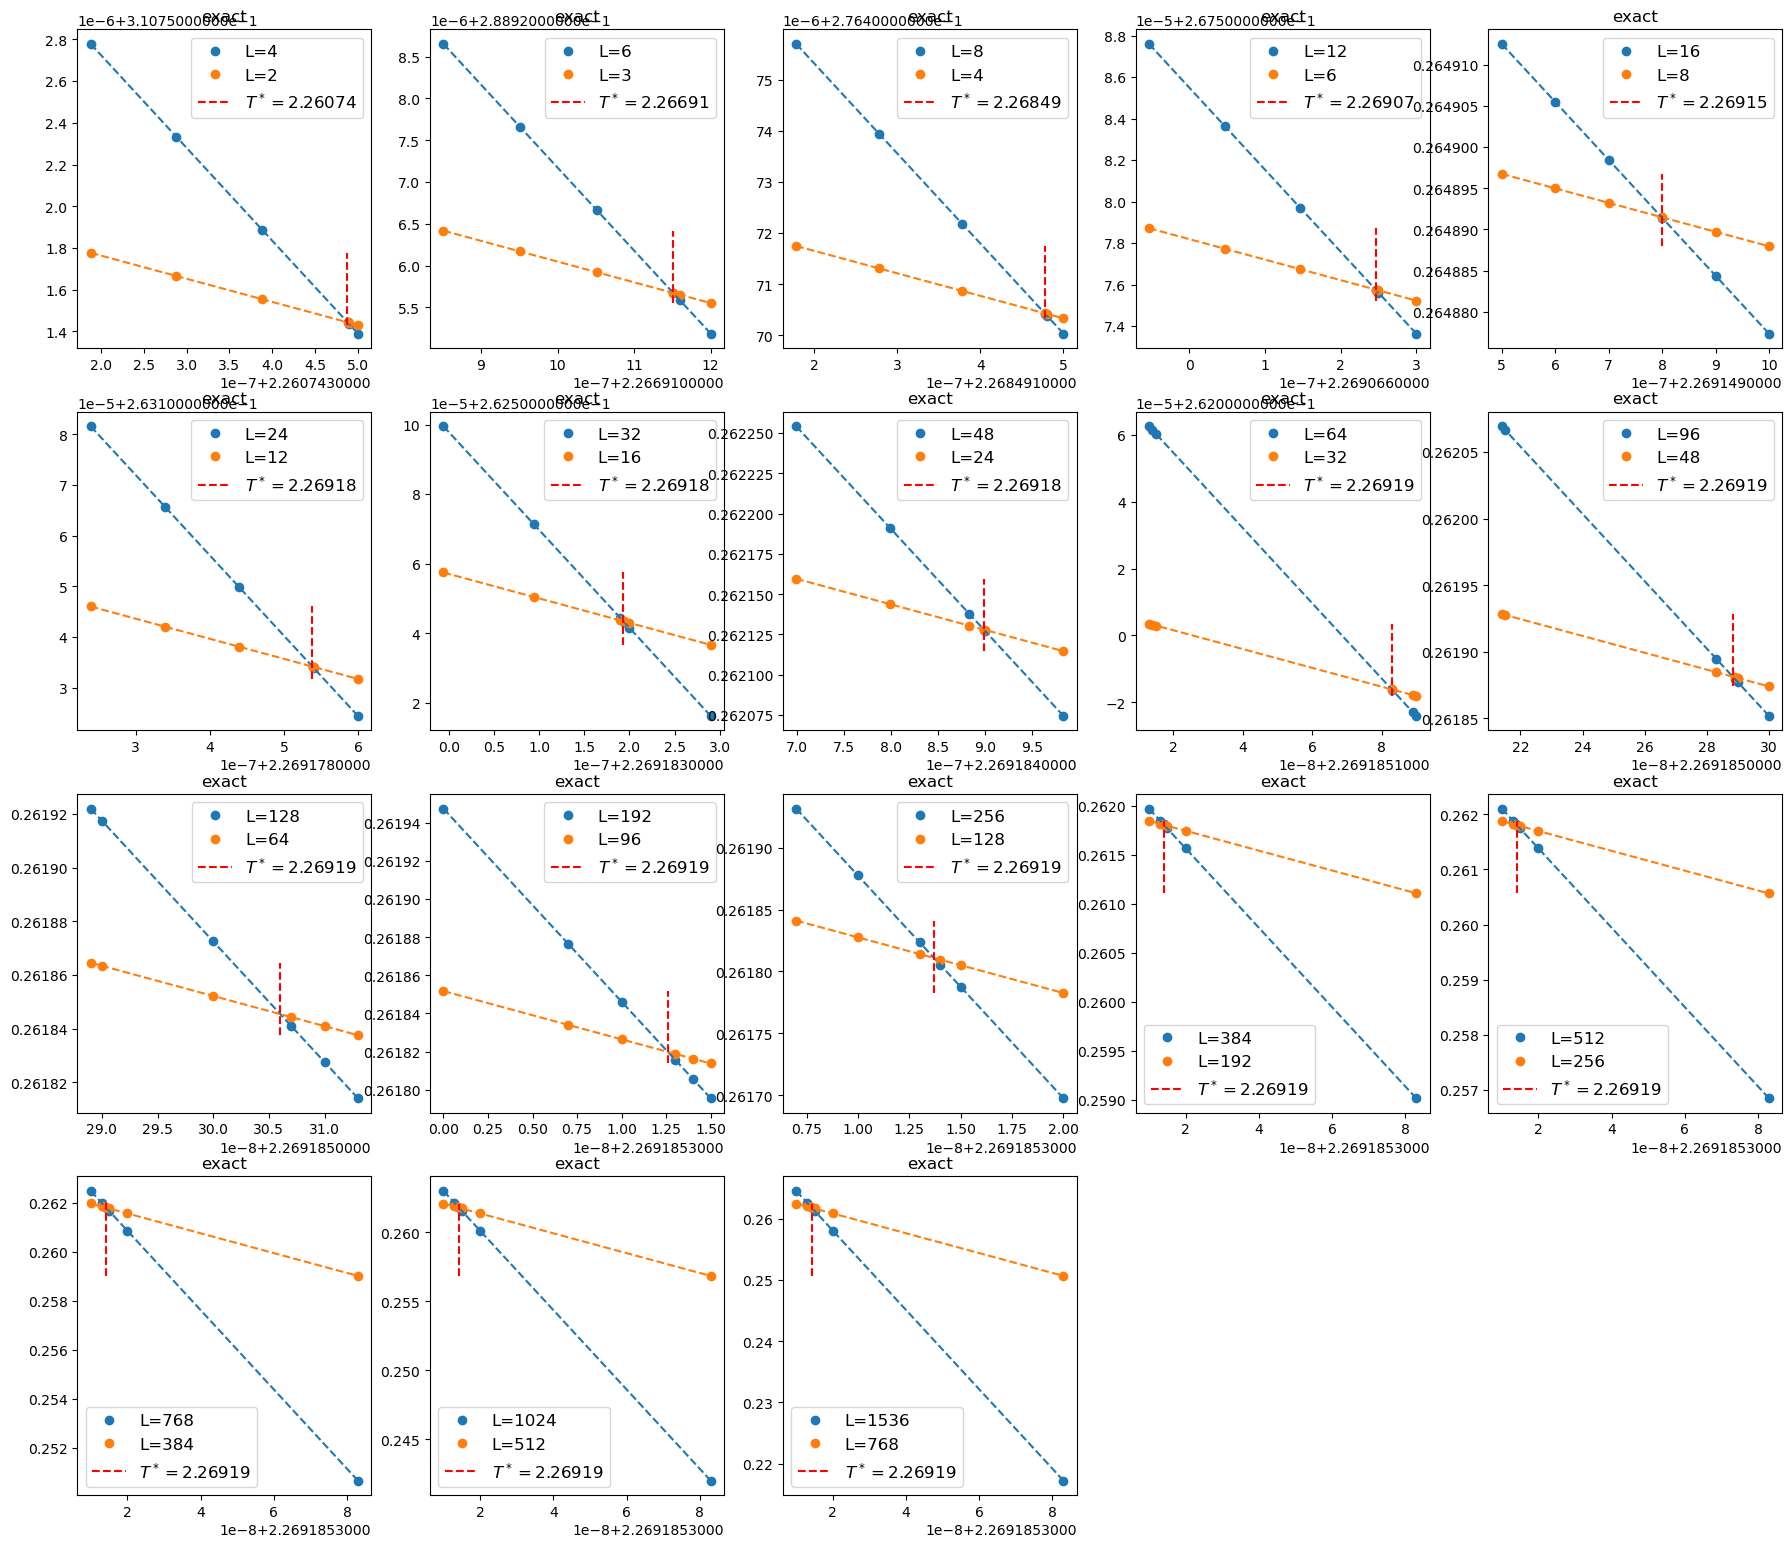

In [89]:
dcuts = ['exact']

Ls1 = 2**np.arange(1,10+1)
Ls2 = (3/2*Ls1).astype('int')
Ls  = np.sort(np.append(Ls1,Ls2))

for dcut in dcuts:
    T_cross_all  = []
    slope_L1_all = []
    slope_L2_all = []
    y_cross_all  = []
    
    Folder = 'free_energy_data'
    df = pd.read_csv(Folder+'/f_L (exact, L_L_over_2).csv')
    # data = pd.read_csv(Folder + '/xi_over_L (exact)_ZoomIter{}.csv'.format(iteration))
    # data = pd.read_csv(FILE4 + 'xi_over_L_(dcut={})_ZoomIter{}.csv'.format(dcut,iteration))
    # data = data[data['T']>2.26]
    # print(data)

    plt.figure(figsize=(22,24)) 
    print(dcut)
    iplot = 0
    for iL,L in enumerate(Ls[2:]): 
        # print('L={}'.format(L))  

        Ts   = df['T'].values
        f_L1 = df['L={}'.format(L)].values
        f_L2 = df['L={}'.format(int(L/2))].values
        y_L1 = ((f_L1 - f_inf) * L**2)
        y_L2 = ((f_L2 - f_inf) * (int(L/2))**2)
        # y_L1 = 1/(y_L1)
        # y_L2 = 1/(y_L2)
        
        cross_id = get_index((y_L2-y_L1))
        T_cross, y_cross, a_L1, a_L2, c_L1, c_L2 = fitting_x0_slope(Ts, y_L1, y_L2)
        T_cross_all.append(T_cross)
        slope_L1_all.append(a_L1)
        slope_L2_all.append(a_L2)
        y_cross_all.append(y_cross)

        if L % 1 == 0:
            print('L={}, dT={}'.format(L,Ts[cross_id+1]-Ts[cross_id]))
            plt.subplot(5,5,iplot+1)
            num_plot = 2
            shift = 0
            plot_range = range(cross_id-num_plot+shift,cross_id+num_plot+2+shift)
            # plot_range = range(0, len(Ts))
            plt.plot(Ts[plot_range], y_L1[plot_range], 'o', label='L={}'.format(L))
            plt.plot(Ts[plot_range], y_L2[plot_range], 'o', label='L={}'.format(int(L/2)))
            plt.plot(Ts[plot_range], a_L1*Ts[plot_range] + c_L1,  'C0--')
            plt.plot(Ts[plot_range], a_L2*Ts[plot_range] + c_L2, 'C1--')
            plt.plot([T_cross,T_cross], [np.min(y_L2[plot_range]),np.max(y_L2[plot_range])], 'r--', label=r'$T^*={:.6}$'.format(T_cross))
            plt.legend(fontsize=12)
            plt.title(dcut)
            plt.tight_layout
            iplot += 1
    plt.show()

    df = pd.DataFrame()
    df['L'] = Ls[2:]
    df['T_cross'] = T_cross_all
    df['slope_(L)'] = slope_L1_all
    df['slope_(L/2)'] = slope_L2_all
    df['nu_cross'] = np.log(1/2)/np.log(np.array(slope_L2_all)/np.array(slope_L1_all))
    # df['nu_cross']  = 1/( np.log(np.array(slope_L1_all)/np.array(slope_L2_all))/(np.log(Ls[1:]/(Ls[1:]-1))) + 1)
    df['y_cross']  = y_cross_all
    df['K_cross']  = 1/np.array(T_cross_all)

    FILE_cross = 'crossing_result'
    makeFolder(FILE_cross)
    df.to_csv(FILE_cross+'/exact_crossing_result_(L,L_over_2).csv')

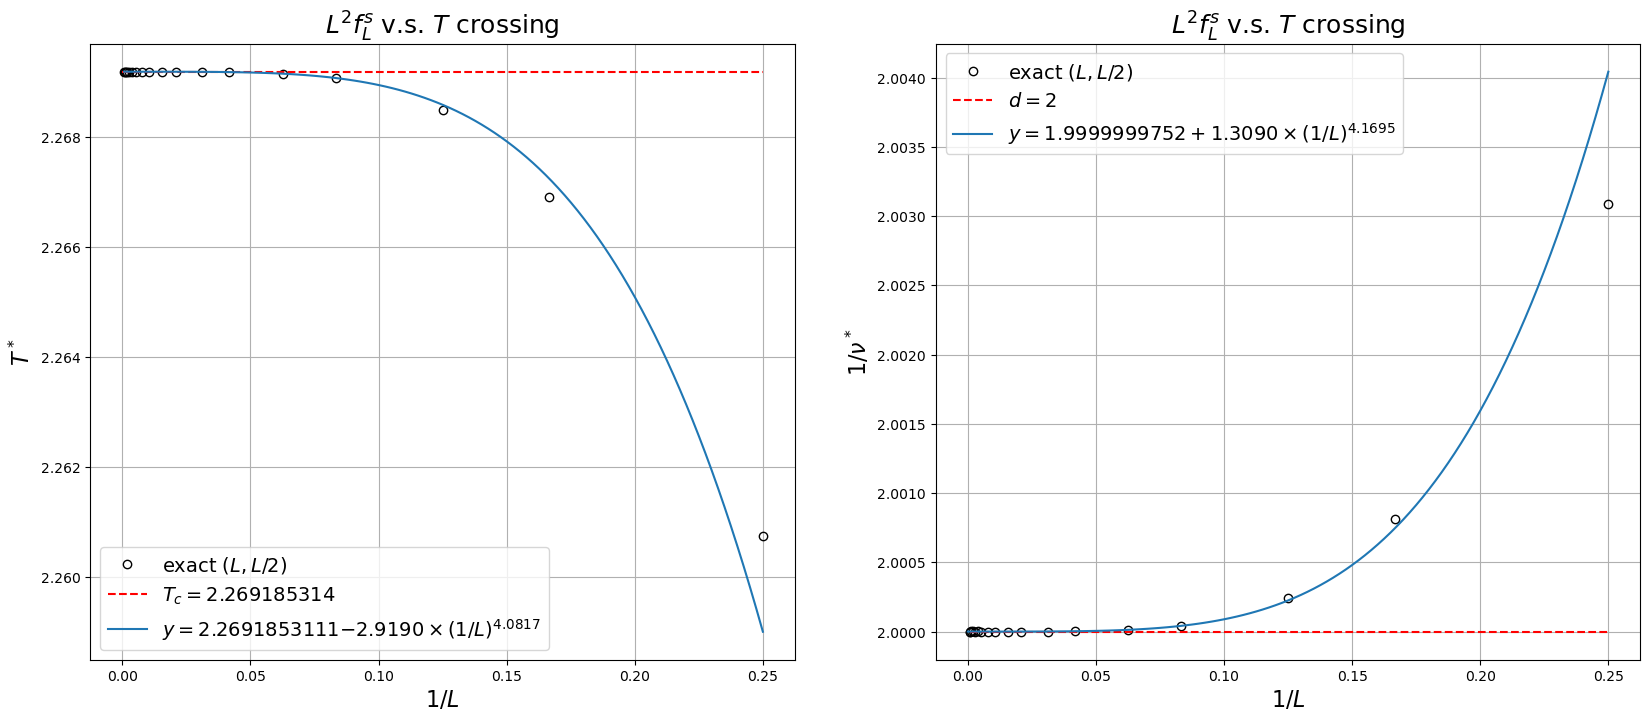

In [95]:
def fitting_fn(x, a, b, c):
    return a + c*x**b
    
ZoomIn = True
Lmin = 16-1 if ZoomIn else 0

FILE_cross = 'crossing_result'
data_exact = pd.read_csv(FILE_cross + '/exact_crossing_result_(L,L_over_2).csv')
Ls_exact = data_exact['L'].values
T_cross_exact  = data_exact['T_cross'].values
nu_cross_exact = data_exact['nu_cross'].values

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
x = (1/Ls_exact) #[Ls_exact>Lmin]
y = T_cross_exact #[Ls_exact>Lmin]

plt.plot(x, y, 'ko', markerfacecolor='none', label='exact $(L,L/2)$')
plt.plot([0, max(x)],[Tc,Tc], 'r--', label=r'$T_c = {:.10}$'.format(Tc))

popt, pcov = curve_fit(fitting_fn, x[Ls_exact>Lmin], y[Ls_exact>Lmin])
T_inf, omega, c = popt
x_fit = np.linspace(min(x),max(x),100+1)
y_fit = fitting_fn(x_fit, T_inf, omega, c)
plt.plot(x_fit, y_fit,'-', label=r'$y={%.10f}{%.4f}\times (1/L)^{%.4f}$' %(T_inf,c, omega))

plt.legend(fontsize=14)
plt.xlabel('$1/L$', fontsize=16)
plt.ylabel('$T^*$', fontsize=16)
plt.grid()
plt.title(r'$L^2 f^s_L$ v.s. $T$ crossing', fontsize=18)
# plt.xlim(0)
# plt.xscale('log')
# plt.yscale('log')
# if ZoomIn:
    # plt.ylim(Tc-2e-6,Tc+3e-5)

plt.subplot(1,2,2)
x = (1/Ls_exact)
y = ((1/nu_cross_exact))

plt.plot(x,y,'ko', markerfacecolor='none', label='exact $(L,L/2)$')
plt.plot([min(x), max(x)],[2,2], 'r--', label=r'$d = {}$'.format(2))

popt, pcov = curve_fit(fitting_fn, x[Ls_exact>Lmin], y[Ls_exact>Lmin])
one_over_nu_inf, omega, c = popt
x_fit = np.linspace(0,max(x),100+1)
y_fit = fitting_fn(x_fit, one_over_nu_inf, omega, c)
plt.plot(x_fit,y_fit,'-', label=r'$y={%.10f} + {%.4f}\times (1/L)^{%.4f}$' %(one_over_nu_inf, c, omega))


plt.legend(fontsize=14)
plt.xlabel('$1/L$', fontsize=16)
plt.ylabel(r'$1/\nu^*$', fontsize=16)
plt.grid()
plt.title(r'$L^2 f^s_L$ v.s. $T$ crossing', fontsize=18)
# plt.xlim(0)
# plt.xscale('log')
# plt.yscale('log')

plt.savefig('T_cross_and_nu_cross (L,L_over_2).pdf')


plt.show()

(Guess)
Assume $b^{y_t} \approx 1$ $\Rightarrow t' = b^{y_t} t = t$ 

$$f^s_L(t) = b^{-d} f^s_{L'}(t')$$
$$L^d f^s_L(t) = (L/b)^{d} f^s_{L'}(t') = {L'}^{d} f^s_{L'}(t')$$

Set the dimensionless quantity $Q(t,L) = L^d f^s_{L}(t,L^{-\omega})$, do the near critical temperature expansion gives

$$Q(t,L) \approx L^d (a_0 + a_1 t + a_2 t^2 + b_0 L^{-\omega} + c_1 t L^{-\omega})$$
$$\Rightarrow s(t,L) = \frac{dQ}{dt} = L^d (a_1 + 2 a_2 t + c_1 L^{-\omega})$$
$$\Rightarrow s(t^*,L) = L^d (a + c L^{-\omega})$$

If we define $\frac{1}{\nu^*(L)} = \frac{\ln[s(t^*,rL)]-\ln[s(t^*,L)]}{\ln(r)}$

$$\frac{\ln(r)}{\nu^*(L)} = \ln[s(t^*,rL)]-\ln[s(t^*,L)] = \ln[(rL)^d (a + c (rL)^{-\omega})] - \ln[L^d (a + c L^{-\omega})]$$

$$ = d\ln(rL) + \ln(a) + \ln[1 + \frac{c}{a} (rL)^{-\omega}]\\
     - d\ln(L) - \ln(a) - \ln[1 + \frac{c}{a} (L)^{-\omega}]
$$

$$
\approx d\ln(rL) + \ln(a) + \frac{c}{a} (rL)^{-\omega}\\
- d\ln(L) + \ln(a) +  \frac{c}{a} (L)^{-\omega}
$$

$$\Rightarrow \frac{1}{\nu^*(L)} = d + const \cdot L^{-\omega}$$

From the fitting result, we get $\omega \approx 4$, which is larger than the exponent $\frac{1}{\nu} + \omega \approx 1 + 2 = 3$ for $\xi/L$ crossing.

In [7]:
def T_list_new(T_cross_all, T_range, N):
    Ts_new = np.empty(0)
    decimals = int(-np.log10(T_range/N)+2)
    print('decimals={}'.format(decimals))
    for iT, T_cross in enumerate(T_cross_all):
        if T_cross != np.NaN:
            # T_cross = np.round(T_cross, decimals)
            Ts = np.linspace(T_cross - T_range/2, T_cross + T_range/2, N+1)
            Ts_new = np.append(Ts_new, Ts)
    Ts_new = np.ceil(Ts_new*10**(decimals))
    Ts_new = np.sort(np.unique(Ts_new))
    Ts_new = Ts_new/10**(decimals)
    return Ts_new

In [8]:
iteration = 7; T_range = 0.6*0.01; N=6

dcuts = ['exact']

T_cross_dict = {}
FILE_cross = 'crossing_result'
for iD,dcut in enumerate(dcuts):
    try:
        df = pd.read_csv(FILE_cross + '/exact_crossing_result_(L,L_over_2).csv')
        T_cross = df['T_cross'].values
        T_cross_all = T_cross
        T_cross_dict['D={}'.format(dcut)] = T_cross_all
    except:
        T_cross_dict['D={}'.format(dcut)] = T_cross_dict['D={}'.format(dcuts[iD-1])]

decimals=5
len(Ts_new) =  49 for D=exact
dT = 0.0009999999999998899
[2.25775 2.25875 2.25975 2.26075 2.26175 2.26275 2.26375 2.26392 2.26492
 2.2655 ]


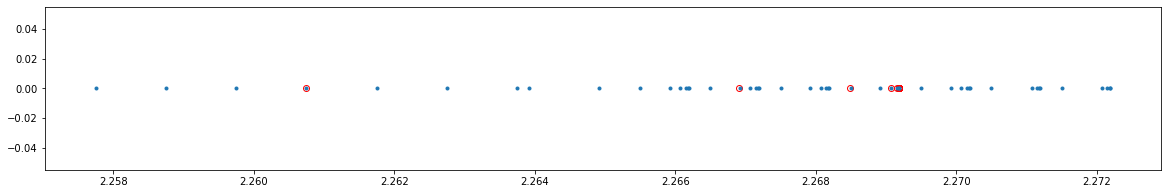

In [9]:
FILE_T_iter = 'T_list_iter2'
makeFolder(FILE_T_iter)

plt.figure(figsize=(20,3))
for dcut in dcuts:
    T_cross_all = T_cross_dict['D={}'.format(dcut)]
    Ts_new = T_list_new(T_cross_all, T_range, N)
    print('len(Ts_new) = ', len(Ts_new), 'for D={}'.format(dcut))
    print('dT = {}'.format(Ts_new[1]-Ts_new[0]))
    print(Ts_new[:10])
    df = pd.DataFrame({'T': Ts_new})
    df.to_csv(FILE_T_iter + '/T_iter_{}_D{}.csv'.format(iteration, dcut))


plt.plot(T_cross_all, np.zeros_like(T_cross_all), 'ro', markerfacecolor='none')
plt.plot(Ts_new, np.zeros_like(Ts_new), '.')
plt.show()